This notebook contains code to preprocess the MEG data such that it is in a format amenable to group-level source imaging via MTW.

In [1]:
import mne
import os
import os.path as op
from mne.parallel import parallel_func
from mne.datasets import hf_sef
from matplotlib import pyplot as plt

from groupmne import group_model
from groupmne.inverse import compute_group_inverse

import pickle

In [2]:
_ = hf_sef.data_path("raw")
data_path = hf_sef.data_path("evoked")
meg_path = data_path + "/MEG/"

data_path = op.expanduser(data_path)
subjects_dir = data_path + "/subjects/"
os.environ['SUBJECTS_DIR'] = subjects_dir

raw_name_s = [meg_path + s for s in ["subject_a/sef_right_raw.fif",
              "subject_b/hf_sef_15min_raw.fif"]]


def process_meg(raw_name):
    """Extract epochs from a raw fif file.

    Parameters
    ----------
    raw_name: str.
        path to the raw fif file.

    Returns
    -------
    epochs: Epochs instance

    """
    raw = mne.io.read_raw_fif(raw_name)
    events = mne.find_events(raw)

    event_id = dict(hf=1)  # event trigger and conditions
    tmin = -0.05  # start of each epoch (50ms before the trigger)
    tmax = 0.3  # end of each epoch (300ms after the trigger)
    baseline = (None, 0)  # means from the first instant to t = 0
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                        baseline=baseline)
    return epochs

Opening raw data file /home/alecgt/mne_data/HF_SEF/MEG/subject_a/sef_right_raw.fif...
    Read a total of 8 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
    Range : 26000 ... 1735999 =      8.667 ...   578.666 secs
Ready.
Opening raw data file /home/alecgt/mne_data/HF_SEF/MEG/subject_a/sef_right_raw-1.fif...
    Read a total of 8 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x

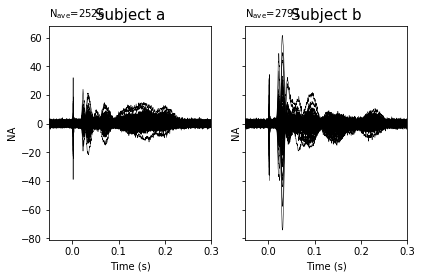

In [3]:
epochs_s = [process_meg(raw_name) for raw_name in raw_name_s]
evoked_s = [ep.average() for ep in epochs_s]

# compute noise covariance (takes a few minutes)
noise_cov_s = []
for subj, ep in zip(["a", "b"], epochs_s):
    cov_fname = meg_path + f"subject_{subj}/sef-cov.fif"
    if os.path.exists(cov_fname):
        cov = mne.read_cov(cov_fname)
    else:
        cov = mne.compute_covariance(ep, tmin=None, tmax=0.)
        mne.write_cov(cov_fname, cov)
    noise_cov_s.append(cov)


f, axes = plt.subplots(1, 2, sharey=True)
for ax, ev, nc, ll in zip(axes.ravel(), evoked_s, noise_cov_s, ["a", "b"]):
    picks = mne.pick_types(ev.info, meg="grad")
    ev.plot(picks=picks, axes=ax, noise_cov=nc, show=False)
    ax.set_title("Subject %s" % ll, fontsize=15)
plt.show()

In [16]:
resolution = 4
spacing = "ico%d" % resolution
src_ref = group_model.get_src_reference(spacing=spacing,
                                        subjects_dir=subjects_dir,
                                       fetch_fsaverage=True)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /home/alecgt/mne_data/HF_SEF/subjects/
Subject      = fsaverage
Surface      = white
Icosahedron subdivision grade 4

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading /home/alecgt/mne_data/HF_SEF/subjects/fsaverage/surf/lh.white...
Mapping lh fsaverage -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /home/alecgt/mne_data/HF_SEF/subjects/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 2562/163842 selected to source space (ico = 4)

Loading /home/alecgt/mne_data/HF_SEF/subjects/fsaverage/surf/rh.white...
Mapping rh fsaverage -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /home/alecgt/mne_data/HF_SEF/subjects/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 2562/163842 selected to source space (ico = 4)

Yo

In [5]:
subjects = ["subject_a", "subject_b"]
trans_fname_s = [meg_path + "%s/sef-trans.fif" % (s) for s in subjects] # changed slightly from example code
bem_fname_s = [subjects_dir + "%s/bem/%s-5120-bem-sol.fif" % (s, s)
               for s in subjects]
n_jobs = 2
parallel, run_func, _ = parallel_func(group_model.compute_fwd, n_jobs=n_jobs)

fwds = parallel(run_func(s, src_ref, info, trans, bem,  mindist=3)
                for s, info, trans, bem in zip(subjects, raw_name_s,
                                               trans_fname_s, bem_fname_s))


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   14.1s finished


In [17]:
src_ref

<SourceSpaces: [<surface (lh), n_vertices=163842, n_used=2562, coordinate_frame=MRI (surface RAS)>, <surface (rh), n_vertices=163842, n_used=2562, coordinate_frame=MRI (surface RAS)>]>

In [12]:
# src_ref_lh = src_ref.pop(1)

In [18]:
gains, M, group_info = \
    group_model.compute_inv_data(fwds, src_ref, evoked_s, noise_cov_s,
                                 ch_type="grad", tmin=0.015, tmax=0.025)
print("(# subjects, # channels, # sources) = ", gains.shape)
print("(# subjects, # channels, # time points) = ", M.shape)

    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]
Mapping lh fsaverage -> subject_a (nearest neighbor)...
Mapping rh fsaverage -> subject_a (nearest neighbor)...
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]
Mapping lh fsaverage -> subject_b (nearest neighbor)...
Mapping rh fsaverage -> subject_b (nearest neighbor)...
    Created an SSP operator (subspace dimension = 3)
Computing data rank from covariance with rank=None
    Using tolerance 2.9e-13 (2.2e-16 eps * 204 dim * 6.4  max singular value)
    Estimated rank (grad): 201
    GRAD: rank 201 computed from 204 data channels with 3 projectors
    Setting small GR

In [19]:
from groupmne.group_model import compute_gains

In [20]:
gains_lh = compute_gains(fwds, src_ref) # gain matrices for left hemisphere only

    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]
Mapping lh fsaverage -> subject_a (nearest neighbor)...
Mapping rh fsaverage -> subject_a (nearest neighbor)...
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]
Mapping lh fsaverage -> subject_b (nearest neighbor)...
Mapping rh fsaverage -> subject_b (nearest neighbor)...


In [28]:
gains_lh[0].shape

(2, 204, 2562)

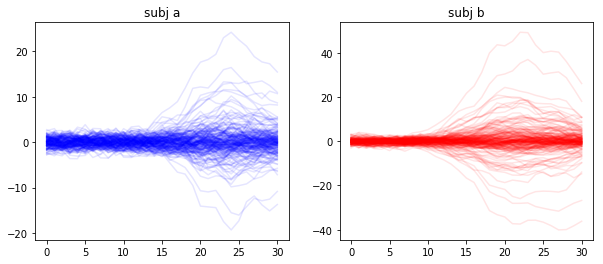

In [29]:
# view
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
for i in range(M.shape[1]):
    plt.plot(M[0,i,:], color='blue', alpha=0.1)
    plt.title('subj a')
    
plt.subplot(1,2,2)
for i in range(M.shape[1]):
    plt.plot(M[1,i,:], color='red', alpha=0.1)
    plt.title('subj b')

plt.show()

In [30]:
# save leadfield matrices and responses

out = {'gain': gains_lh[0], 'M': M}
outfile = '../data/MEG_preprocessed.pkl'

with open(outfile, 'wb') as f:
    pickle.dump(out, f)